In [22]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import glob
import re

In [23]:
class Node:
    def __init__(self, l, num_packets, i):
        self.i=i
        self.l=l
        self.num_packets=num_packets
        self.inter_arrival_times=np.random.exponential(1/l, (num_packets))
        self.arrival_times=np.cumsum(self.inter_arrival_times)
        self.max_time=int(np.ceil(np.amax(self.arrival_times))+1) #transmitting till max_time
        self.queue=[]
        self.collisions=0
        self.successes=0
        self.transmit_flag=0
    
    def receive(self, t):
        #arrivals in (t-1, t) are appended to the queue
        for timestamp in self.arrival_times:
            if(t==np.ceil(timestamp)):
                self.queue.append(Packet(timestamp, self.i))
    def transmit(self, t):
        #if no collisions, and the queue is non-empty, transmit immediately
        if(self.collisions==0):
            if(len(self.queue)>0):
                transmitted_packet=self.queue[0]
                transmitted_packet.t_time=t
                self.transmit_flag=1
                return transmitted_packet
            else:
                self.transmit_flag=0
                return 0
        else:
            #collided packet
            if(len(self.queue)>0):
                if(self.queue[0].t_time==t):
                    transmitted_packet=self.queue[0]
                    transmitted_packet.t_time=t
                    self.transmit_flag=1
                    return transmitted_packet
                else:
                    self.transmit_flag=0
                    return 0
    def generate(self, t):
        if(t==int(self.max_time-1)):
            self.inter_arrival_times=np.append(self.inter_arrival_times, (np.random.exponential(1/self.l, (15))))
            self.arrival_times=np.cumsum(self.inter_arrival_times)
            self.max_time=int(np.ceil(np.amax(self.arrival_times))+1)
        

class Packet:
    def __init__(self, timestamp, i):
        self.timestamp=timestamp
        self.t_time=0
        self.i=i
        self.collisions=0

def end_sim(mynodes, t, t_end):
    temp=1
    '''    for node in mynodes:
        
        if(t<=node.max_time):
            temp=0
        elif(node.queue and t>node.max_time):
            temp=0
        '''
        
    '''
    if(not node.queue and t>node.max_time):
        temp=1
    else:
        temp=0
    '''
    if(t<=t_end):
        temp=0
    else:
        temp=1

def s_aloha_for_input(G, nodes, packets=20, cw_min=32, cw_max=256, t_end=500, max_attempts=8):
    r_pkt=[]
    mynodes=[Node(G/nodes, packets, i) for i in range(nodes)]
#        max_time=np.amax([mynodes[i].max_time for i in range(nodes)])
    t=0
    start_flag=0
    t_start=100
    age=np.zeros(t_end+1)
    peaks=[]
#    print("Time, transmission time, Node, Collisions, Timestamp")
    while(t<=t_end):
        actives=[]
        t_packets=[]
        for node in mynodes:
            node.generate(t)
            node.receive(t)
            pkt=node.transmit(t)
            if(pkt!=0):
                #print(pkt.timestamp, pkt.i)
                actives.append(node)
                t_packets.append(pkt)
            if(pkt==0):
                pass
                #print(t)
        #print([active.i for active in actives])
        if(len(actives)>1):
            #collision
            for active in actives:
                active.collisions+=1
                active.queue[0].collisions+=1
                if(1<=active.queue[0].collisions<=max_attempts):
                    backoff=np.random.randint(1, int(2**(active.collisions)))
                    #backoff=np.random.randint(0, int(2**(active.collisions)*cw_min)-1)
                    active.queue[0].t_time=t+backoff
                else:
                    dropped_pkt=active.queue.pop(0)
                    active.collisions=0
            if(t>=t_start):
                age[t]=age[t-1]+1
            else:
                age[t]=age[t-1]
                #print(t, t+backoff, active.i, active.collisions, np.around(active.queue[0].timestamp, 2))
        elif(len(actives)==1):
            actives[0].collisions=0
            actives[0].successes+=1
            s_pkt=actives[0].queue.pop(0)
            s_pkt.t_time=t
            r_pkt.append(s_pkt)
            if(t>=t_start):
                if((t-s_pkt.timestamp)<=age[t-1]):
                    age[t]=(t-s_pkt.timestamp)
                    peaks.append(age[t-1]-age[t])
                else:
                    age[t]=age[t-1]+1
            else:
                age[t]=age[t-1]
        else:
            if(t>=t_start):
                age[t]=age[t-1]+1
            else:
                age[t]=age[t-1]
        t+=1
    max_time=t
    delay=0
    tput=0
    t_pkt=[]
    for pkt in r_pkt:
        if(pkt.t_time>=t_start):
            delay+=pkt.t_time-pkt.timestamp
            tput+=1
            t_pkt.append(pkt)
    delay/=len(t_pkt)
    #print(len(t_pkt), G, nodes)
    tput/=float(max_time-t_start)
    peaks=np.array(peaks)
    return t_pkt, tput, delay, age, peaks        

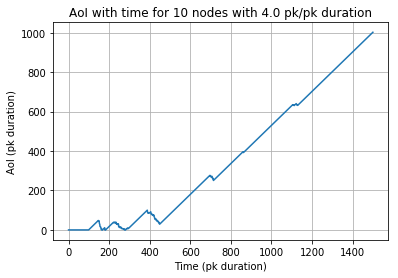

In [40]:
t_pkt, tput, delay, age, peaks = s_aloha_for_input(4.0, 10, t_end=1500, max_attempts=8)
plt.plot(age)
plt.grid()
plt.title("AoI with time for 10 nodes with 4.0 pk/pk duration")
plt.xlabel("Time (pk duration)")
plt.ylabel("AoI (pk duration)")
plt.savefig("AoI with time for 10 nodes")

4 done.
10 done.
30 done.
50 done.


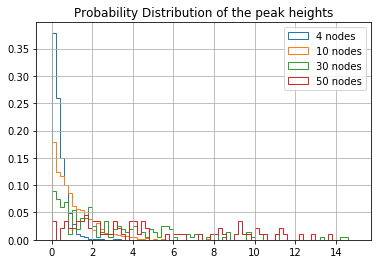

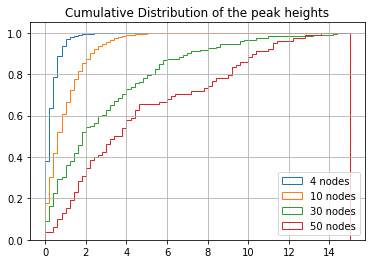

In [316]:
input_nodes=[4, 10, 30, 50]
results=[]
for nodes in input_nodes:
    peaks_total=[]
    for i in range(10):
        t_pkt, tput, delay, age, peaks = s_aloha(10.0, nodes, t_end=2000)
        if(i==0):
            peaks_total=np.array(peaks)
        else:
            peaks_total=np.append(peaks_total, peaks)
    print("{} done.".format(nodes))
    peaks_total=np.array(peaks_total)
    peaks_total=peaks_total.flatten()
    results.append(peaks_total)
    plt.figure(7)
    plt.title("Cumulative Distribution of the peak heights")
    plt.hist(peaks_total, density=True, cumulative=True,bins=75, histtype='step',range=(0, 15) ,label="{} nodes".format(nodes))
    plt.legend(loc='lower right')
    plt.figure(8)
    plt.title("Probability Distribution of the peak heights")
    plt.hist(peaks_total, density=False, bins=75, range=(0,15), weights=np.ones(len(peaks_total))/len(peaks_total), histtype='step', label="{} nodes".format(nodes))
    plt.legend()
plt.figure(8)
plt.grid()
plt.savefig("Probability Distribution of the peak heights (nodes)")
plt.figure(7)
plt.grid()
plt.savefig("Cumulative Distribution of the peak heights (nodes)")


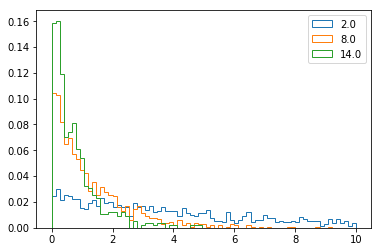

In [309]:
results=np.array(results)
i=0
for G in input_G:
    plt.hist(results[i], histtype='step', label="{}".format(G), density=False, bins=75, range=(0,10), weights=np.ones(len(results[i]))/len(results[i]))
    i+=1
plt.legend()

(array([163., 129.,  76.,  83.,  66.,  54.,  28.,  38.,  27.,  30.,  21.,
         13.,  13.,   9.,   6.,   7.,   8.,   2.,   6.,   5.,   1.,   3.,
          2.,   1.,   2.,   1.,   2.,   1.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ]),
 <a list of 1 Patch objects>)

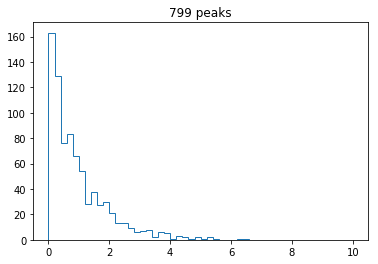

In [251]:
peaks_total=np.array(peaks_total)
peaks_total=peaks_total.flatten()
plt.figure(6)
plt.title("{} peaks".format(len(peaks_total)))
plt.hist(peaks_total, bins=50, density=False, cumulative=False, histtype='step', range=(0, 10))

(5,)

In [171]:
print(len([pkt.t_time for pkt in results[0]]))

619


In [18]:
def s_aloha_with_backoff(nodes, packets, epochs, points=25, G_max=10, cw_min=32, cw_max=256, t_end=500, max_attempts=8):    
    input_G=np.linspace(0.1, G_max, points, dtype='float')
    avr_results=np.zeros(len(input_G))
    avr_delay=np.zeros(len(input_G))
    avr_age=np.zeros(len(input_G))
    for epoch in range(epochs):
        results=[]
        delay_results=[]
        age_results=[]
        for G in input_G:
            r_pkt=[]
            mynodes=[Node(G/nodes, packets, i) for i in range(nodes)]
    #        max_time=np.amax([mynodes[i].max_time for i in range(nodes)])
            t=0
            start_flag=0
            t_start=100
            age=np.zeros(t_end+1)
        #    print("Time, transmission time, Node, Collisions, Timestamp")
            while(t<=t_end):
                actives=[]
                t_packets=[]
                for node in mynodes:
                    node.generate(t)
                    node.receive(t)
                    pkt=node.transmit(t)
                    if(pkt!=0):
                        #print(pkt.timestamp, pkt.i)
                        actives.append(node)
                        t_packets.append(pkt)
                    if(pkt==0):
                        pass
                        #print(t)
                #print([active.i for active in actives])
                if(len(actives)>1):
                    #collision
                    #print([[active.i, len(active.queue), active.collisions] for active in actives], t)
                    for active in actives:
                        active.collisions+=1
                        active.queue[0].collisions+=1
                        if(1<=active.queue[0].collisions<=max_attempts):
                            backoff=np.random.randint(1, int(2**(active.collisions)))
                        #backoff=np.random.randint(0, int(2**(active.collisions)*cw_min)-1)
                            active.queue[0].t_time=t+backoff
                        else:
                            dropped_pkt=active.queue.pop(0)
                            active.collisions=0
                            #print(G, nodes,"dropped " , dropped_pkt.collisions, np.around(dropped_pkt.timestamp, 2))
                    if(t>=t_start):
                        age[t]=age[t-1]+1
                    else:
                        age[t]=age[t-1]
                        #print(t, t+backoff, active.i, active.collisions, np.around(active.queue[0].timestamp, 2))
                elif(len(actives)==1):
                    actives[0].collisions=0
                    actives[0].successes+=1
                    s_pkt=actives[0].queue.pop(0)
                    s_pkt.t_time=t
                    r_pkt.append(s_pkt)
                    if(t>=t_start):
                        if((t-s_pkt.timestamp)<=age[t-1]):
                            age[t]=(t-s_pkt.timestamp)
                        else:
                            age[t]=age[t-1]+1
                    else:
                        age[t]=age[t-1]
                else:
                    if(t>=t_start):
                        age[t]=age[t-1]+1
                    else:
                        age[t]=age[t-1]
                t+=1
            """
              if(np.around(G, 2)==10):
                plt.figure(1)
                time_arr=np.arange(t)
                age=np.array(age)
                plt.plot(time_arr[:], age[1:])
                plt.plot(time_arr[:], time_arr[:]) 
            """
                    #print(t, t, actives[0].i, actives[0].collisions, np.around(s_pkt.timestamp, 2))
            #print(t)
            #print([[elem.t_time for elem in node.queue] for node in mynodes])
            #print([[pkt.t_time, pkt.i, pkt.collisions, np.around(pkt.timestamp, 2)] for pkt in r_pkt])
            max_time=t
            #print(t_start, max_time,(np.amax([node.max_time for node in mynodes]), G))
            #print([node.max_time for node in mynodes], G, nodes)
            delay=0
            tput=0
            t_pkt=[]
            for pkt in r_pkt:
                if(pkt.t_time>=t_start):
                    delay+=pkt.t_time-pkt.timestamp
                    tput+=1
                    t_pkt.append(pkt)
            delay/=len(t_pkt)
            #print(delay, len(t_pkt), G/nodes)
            print(len(t_pkt), G, nodes)
            tput/=float(max_time-t_start)#t_start
            average_age=np.sum(age[t_start:t_end])/float(len(age[t_start:t_end]))
            age_results.append(average_age)
            delay_results.append(delay)
            total_successes=0
            #print(float(G), len(r_pkt), max_time)
            results.append(tput)
        results=np.array(results)
        delay_results=np.array(delay_results)
        age_results=np.array(age_results)
        avr_delay+=delay_results
        avr_results+=results
        avr_age+=age_results
    avr_results/=float(epochs)
    avr_delay/=float(epochs)
    avr_age/=float(epochs)
    data={"load":input_G, "tput":avr_results, "delay":avr_delay, "age":avr_age}
    df=pd.DataFrame(data=data)
    df.to_csv("s-aloha-backoff-{}-nodes-{}-packets-new-{}.csv".format(nodes, packets, t_end))
    return input_G, avr_results, avr_delay

In [20]:
nodes_list=[10, 30, 50]
packets=20
for node_val in nodes_list:
    input_G, avr_results, avr_delay = s_aloha_with_backoff(node_val, packets, 1, 50, 50, t_end=600, max_attempts=8)
    

(45, 0.1, 10)
(286, 1.1183673469387756, 10)
(340, 2.136734693877551, 10)
(344, 3.1551020408163266, 10)
(381, 4.173469387755102, 10)
(342, 5.191836734693878, 10)
(358, 6.210204081632653, 10)
(355, 7.228571428571428, 10)
(353, 8.246938775510204, 10)
(357, 9.26530612244898, 10)
(369, 10.283673469387756, 10)
(351, 11.30204081632653, 10)
(380, 12.320408163265306, 10)
(380, 13.338775510204082, 10)
(345, 14.357142857142856, 10)
(362, 15.375510204081632, 10)
(350, 16.39387755102041, 10)
(367, 17.412244897959184, 10)
(375, 18.43061224489796, 10)
(339, 19.448979591836736, 10)
(359, 20.467346938775513, 10)
(364, 21.485714285714288, 10)
(367, 22.50408163265306, 10)
(380, 23.52244897959184, 10)
(369, 24.540816326530614, 10)
(349, 25.559183673469388, 10)
(352, 26.577551020408166, 10)
(332, 27.59591836734694, 10)
(354, 28.614285714285714, 10)
(378, 29.63265306122449, 10)
(379, 30.651020408163266, 10)
(362, 31.669387755102044, 10)
(370, 32.68775510204082, 10)
(343, 33.70612244897959, 10)
(363, 34.7244

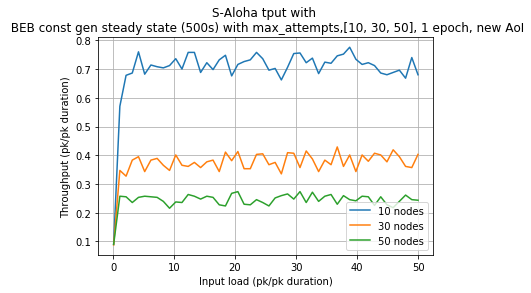

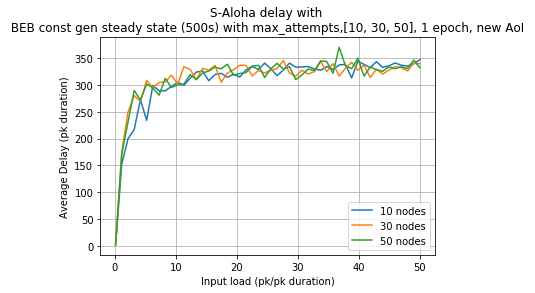

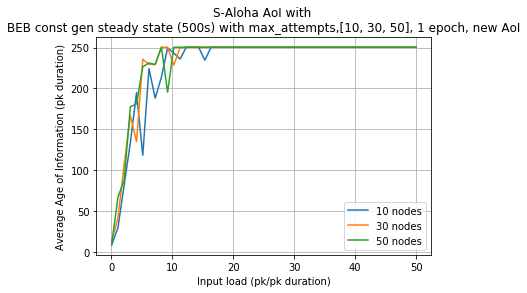

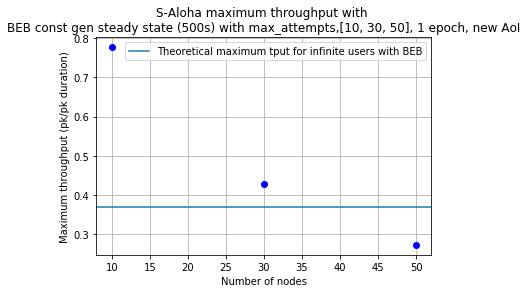

In [21]:
max_tput=[]
nodes_list_total=[10, 30, 50]
tag="BEB const gen steady state (500s) with max_attempts,{}, 1 epoch, new AoI".format(nodes_list_total)
for node_val in nodes_list_total:
    df=pd.read_csv("s-aloha-backoff-{}-nodes-{}-packets-new-600.csv".format(node_val, packets))
    max_tput.append(np.amax(df['tput']))
    plt.figure(1)
    plt.plot(df['load'], df['tput'], label="{} nodes".format(node_val))
    plt.legend()
    plt.xlabel("Input load (pk/pk duration)")
    plt.ylabel("Throughput (pk/pk duration)")
    plt.title("S-Aloha tput with \n {}".format(tag))
    plt.figure(2)
    plt.plot(df['load'], df['delay'], label="{} nodes".format(node_val))
    plt.legend()
    plt.xlabel("Input load (pk/pk duration)")
    plt.ylabel("Average Delay (pk duration)")
    plt.title("S-Aloha delay with \n {} ".format(tag))
    plt.figure(3)
    plt.plot(df['load'], df['age'], label="{} nodes".format(node_val))
    plt.legend()
    plt.xlabel("Input load (pk/pk duration)")
    plt.ylabel("Average Age of Information (pk duration)")
    plt.title("S-Aloha AoI with \n{}".format(tag))
plt.figure(1)
plt.grid()
plt.savefig("S-Aloha tput with {}".format(tag))
plt.figure(2)
plt.grid()
plt.savefig("S-Aloha delay with {} ".format(tag))
plt.figure(3)
plt.grid()
plt.savefig("S-Aloha Age of Information with {}".format(tag))
plt.figure(4)
plt.grid()
plt.plot(nodes_list_total, max_tput, 'ob')
plt.xlabel("Number of nodes")
plt.ylabel("Maximum throughput (pk/pk duration)")
plt.title("S-Aloha maximum throughput with \n{}".format(tag))
plt.axhline(y=0.3706, label="Theoretical maximum tput for infinite users with BEB")
plt.legend()
plt.savefig("Max throughput variation with number of users with {}".format(tag))


In [64]:
G_max=input_G[np.argmax(avr_results)]
throughput_max=np.amax(avr_results)

Text(0,0.15,'Observed Max Throughput=0.5787 at Load=5.05')

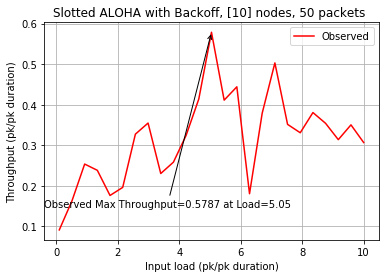

In [65]:
plt.plot(input_G, avr_results, '-r', label='Observed')
plt.title("Slotted ALOHA with Backoff, {} nodes, {} packets ".format(nodes, packets))
plt.legend()
plt.xlabel("Input load (pk/pk duration)")
plt.ylabel("Throughput (pk/pk duration)")
plt.grid()
localtime = time.asctime( time.localtime(time.time()) )
plt.annotate("Observed Max Throughput={} at Load={}".format(np.around(throughput_max,4), G_max), xy=(G_max, throughput_max) , arrowprops=dict(arrowstyle="->"), textcoords='axes fraction', xytext=(0,0.15))
#plt.savefig("s-aloha-with-backoff at {}".format(localtime))

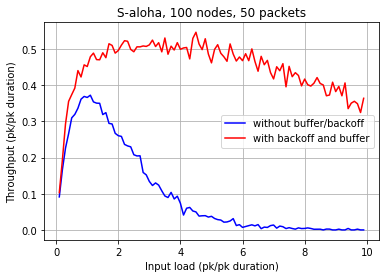

In [350]:
localtime = time.asctime( time.localtime(time.time()) )
df1=pd.read_csv("s-aloha-latest.csv")
plt.plot(df1['load'], df1['tput'], '-b', label='without buffer/backoff')
df2=pd.read_csv("s-aloha-backoff-latest.csv")
plt.plot(df2['load'], df2['tput'], '-r', label='with backoff and buffer')
plt.title("S-aloha, {} nodes, {} packets".format(nodes, packets))
plt.legend()
plt.xlabel("Input load (pk/pk duration)")
plt.ylabel("Throughput (pk/pk duration)")
plt.grid()
plt.savefig("Comparison at {}".format(localtime))

In [351]:
df4=pd.read_csv("s-aloha-backoff-4-nodes-50-packets.csv")
df10=pd.read_csv("s-aloha-backoff-10-nodes-50-packets.csv")
df20=pd.read_csv("s-aloha-backoff-20-nodes-50-packets.csv")
df30=pd.read_csv("s-aloha-backoff-30-nodes-50-packets.csv")
df50=pd.read_csv("s-aloha-backoff-50-nodes-50-packets.csv")
df75=pd.read_csv("s-aloha-backoff-75-nodes-50-packets.csv")
df100=pd.read_csv("s-aloha-backoff-100-nodes-50-packets.csv")

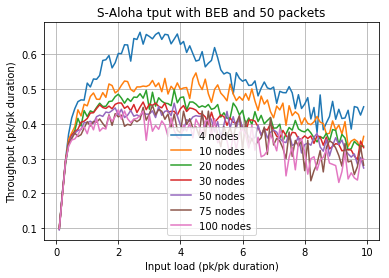

In [352]:
plt.plot(df4['load'], df4['tput'], label="4 nodes")
plt.plot(df10['load'], df10['tput'], label="10 nodes")
plt.plot(df20['load'], df20['tput'], label="20 nodes")
plt.plot(df30['load'], df30['tput'], label="30 nodes")
plt.plot(df50['load'], df50['tput'], label="50 nodes")
plt.plot(df75['load'], df75['tput'], label="75 nodes")
plt.plot(df100['load'], df100['tput'], label="100 nodes")
plt.legend()
plt.xlabel("Input load (pk/pk duration)")
plt.ylabel("Throughput (pk/pk duration)")
plt.title("S-Aloha tput with BEB and 50 packets")
plt.grid()
plt.savefig("S-Aloha tput with BEB and 50 packets")

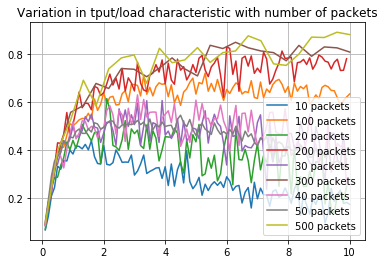

In [56]:
for filename in glob.glob("./*10-nodes*.csv"):
    df=pd.read_csv(filename)
    temp=re.findall(r'\d+', filename)
    plt.plot(df['load'], df['tput'], label="{} packets".format(int(temp[1])))
    plt.legend()
plt.grid()
plt.title("Variation in tput/load characteristic with number of packets")
plt.savefig("Variation in tput-load characteristic with number of packets")

./s-aloha-backoff-10-nodes-50-packets-new.csv


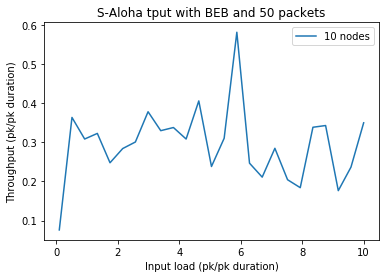

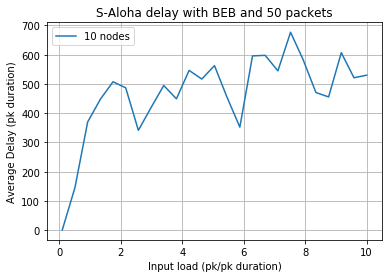

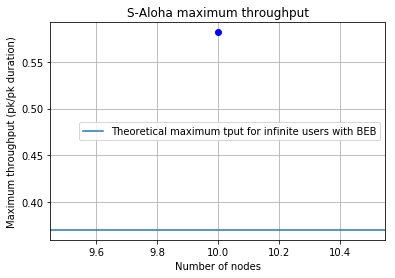

In [60]:
max_tput=[]
load=[]
nodes=[]

for filename in glob.glob("./s-aloha-backoff-*-nodes-50-packets-new.csv"):
    df=pd.read_csv(filename)
    print(filename)
    max_tput.append(np.amax(df['tput']))
    temp=re.findall(r'\d+', filename)
    nodes.append(int(temp[0]))
    plt.figure(1)
    plt.grid()
    plt.plot(df['load'], df['tput'], label="{} nodes".format(int(temp[0])))
    plt.legend()
    plt.grid()
    plt.xlabel("Input load (pk/pk duration)")
    plt.ylabel("Throughput (pk/pk duration)")
    plt.title("S-Aloha tput with BEB and 50 packets")
    plt.figure(2)
    plt.plot(df['load'], df['delay'], label="{} nodes".format(int(temp[0])))
    plt.legend()
    plt.xlabel("Input load (pk/pk duration)")
    plt.ylabel("Average Delay (pk duration)")
    plt.title("S-Aloha delay with BEB and 50 packets")
plt.grid()
plt.savefig("S-Aloha delay with BEB and 50 packets")
plt.figure(3)
plt.plot( nodes, max_tput, 'ob')
plt.grid()
plt.xlabel("Number of nodes")
plt.ylabel("Maximum throughput (pk/pk duration)")
plt.title("S-Aloha maximum throughput")
plt.axhline(y=0.3706, label="Theoretical maximum tput for infinite users with BEB")
plt.legend()
plt.savefig("Max throughput variation with number of users")



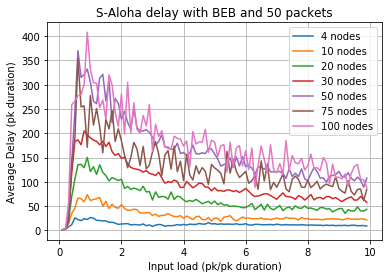

In [291]:
plt.plot(df4['load'], df4['delay'], label="4 nodes")
plt.plot(df10['load'], df10['delay'], label="10 nodes")
plt.plot(df20['load'], df20['delay'], label="20 nodes")
plt.plot(df30['load'], df30['delay'], label="30 nodes")
plt.plot(df50['load'], df50['delay'], label="50 nodes")
plt.plot(df75['load'], df75['delay'], label="75 nodes")
plt.plot(df100['load'], df100['delay'], label="100 nodes")
plt.legend()
plt.xlabel("Input load (pk/pk duration)")
plt.ylabel("Average Delay (pk duration)")
plt.title("S-Aloha delay with BEB and 50 packets")
plt.grid()
plt.savefig("S-Aloha delay with BEB and 50 packets")